In [0]:
# import pandas as pd

# import psycopg2

from google.colab import drive
drive.mount('drive')


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf
import datetime 

# importing copy module 
import copy 
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras import metrics
from keras.callbacks import TensorBoard


from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler #, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
import sys

import warnings
warnings.filterwarnings("ignore")


# !pip install hyperas

from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback

#local

#import LstmPreproc  as ma


s=[]

for i in range(100001):
        if(i%2==0):
            s.append(-1)
        if(i%2 !=0):
            s.append(1)
            
data = pd.DataFrame(s, columns= ['signal'])


data.iloc[40:45]=np.nan

# data.iloc[80]= np.nan

data.iloc[140:145]=np.nan

data.iloc[240:243]=np.nan



data.to_csv('synthetic.csv')

!cp synthetic.csv drive/My\ Drive/Colab\ Notebooks


df_null= (data.isnull() + 0.).values
    
        
# def cume(df):     
#     return  df.signal.isnull().astype(int).groupby(df.signal.notnull().astype(int).cumsum()).sum()


df = data.copy()


# ### find gaps
gaps = []

# # assumes first value of couplet is gap beginning and 2nd value is the end
for i in range(1,len(df_null)):
     if (df_null[i-1] == 0. and df_null[i] == 1.) or (df_null[i-1] == 1. and df_null[i] == 0.):
         gaps.append(i)

print(gaps)
       
  
for i in range(0,len(gaps),2):
    if(gaps[i+1]-gaps[i] != 1):
         df.loc[gaps[i+1],'distance'] = gaps[i+1]-gaps[i]
         df['distance'].iloc[gaps[i]:gaps[i+1]] = 0.0
    else:
         df.loc[gaps[i+1],'distance'] = (gaps[i+1]-gaps[i]) + 1
    
df['distance'] = df['distance'].fillna(1)


Dataset = df 

Dataset.dropna(axis = 0, inplace = True, how='any')






Dataset.to_csv('synthetic_w_elapsedTime.csv')

!cp synthetic_w_elapsedTime.csv drive/My\ Drive/Colab\ Notebooks
#df.signal.plot(figsize=(19,10))

print( Dataset.head(50))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at drive


Using TensorFlow backend.


[40, 45, 140, 145, 240, 243]
    signal  distance
0     -1.0       1.0
1      1.0       1.0
2     -1.0       1.0
3      1.0       1.0
4     -1.0       1.0
5      1.0       1.0
6     -1.0       1.0
7      1.0       1.0
8     -1.0       1.0
9      1.0       1.0
10    -1.0       1.0
11     1.0       1.0
12    -1.0       1.0
13     1.0       1.0
14    -1.0       1.0
15     1.0       1.0
16    -1.0       1.0
17     1.0       1.0
18    -1.0       1.0
19     1.0       1.0
20    -1.0       1.0
21     1.0       1.0
22    -1.0       1.0
23     1.0       1.0
24    -1.0       1.0
25     1.0       1.0
26    -1.0       1.0
27     1.0       1.0
28    -1.0       1.0
29     1.0       1.0
30    -1.0       1.0
31     1.0       1.0
32    -1.0       1.0
33     1.0       1.0
34    -1.0       1.0
35     1.0       1.0
36    -1.0       1.0
37     1.0       1.0
38    -1.0       1.0
39     1.0       1.0
45     1.0       5.0
46    -1.0       1.0
47     1.0       1.0
48    -1.0       1.0
49     1.0       1.0
50   

In [0]:
def get_non_null(df):
    lngth = min(list(len(col.dropna()) for ind, col in df.iteritems()))
    df = pd.concat(list(df.loc[:,col].dropna().head(lngth).reset_index(drop=True) for col in df),axis=1)
    return df
  
  
  
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data
  
  

####################################################################

# My package for preprocessing for training
  
####################################################################### 

def countcensor(dfx):
    '''
    function to identify and count values in dataframe columns that are censored (==0) or
    negative values. Asks to convert the values to the lowest positive, non-zero value in the 
    column.
    Input = dataframe of raw data
    Output = dataframe of data cleaned of censored values or original data
    '''    
    names = list(dfx)
    censor_count = []
    dfx_length = len(dfx.columns)
    print("\nCensored data in each feature:")
    for i in range(dfx_length):
        censor_count.append((dfx.iloc[:,i]<=0.).sum())  ## count values and add to list
        print('{0:4s} {1:2d}'.format(names[i], censor_count[i]))
   
    try:
        censor_correct = input("Convert censored and negative data to lowest positive value? (Default = n)? ")
    except ValueError:
        censor_correct = "y"
        
    if censor_correct == "y":
        ##### if feature has censored data or negative data, replace it 
        ##### with the smallest positive, non-zero value
        print("\nFeature minimum positive values:") ### for space
        
        for i in range(dfx_length):
            if censor_count[i]>0:
                xarray = np.asarray(dfx.iloc[:,i].sort_values())  #sort column and convert to array
                xmin = xarray[censor_count[i]+1] #select smallest, positive, non-zero value
                dfx.iloc[:,i][dfx.iloc[:,i]<= 0.] = xmin  ### replace censored values with min value
            else:
                xmin = 0.
            print('{0:4s} {1:3f}'.format(names[i], xmin))        
        print("\nCensored and negative values converted to feature's smallest positive, non-zero value.")
        
    else:
        print("\nCensored and negative values not converted.")
 
    return dfx
#################################################################


def checkoutliers(dfx):
    '''
    function to identify and count possible outliers in dataframe columns 
    Input = dataframe of data
    Output = none
    ''' 
    names = list(dfx)
    out_count = []
    dfx_length = len(dfx.columns)
    print("\nPossible outliers in each feature:")
    for i in range(dfx_length):
        dfx_test = 3*dfx.iloc[:,i].mean()  ##define test for outlier
        out_count.append((dfx.iloc[:,i]>dfx_test).sum())  ## count values and add to list
        #print(names[i])
        #print(out_count[i],'\n')
    return

def checknans(dfx):
    '''
    function to identify and count NaNs in dataframe columns 
    Input = dataframe of data
    Output = none
    ''' 
    names = list(dfx)
    nan_count = []
    dfx_length = len(dfx.columns)
    print("\nNaN data in each feature:")
    for i in range(dfx_length):
        nan_count.append(dfx.iloc[:,i].isnull().sum())  ## count values and add to list
        #print(names[i] )
        #print(nan_count[i])
    return

def badzeros(dfx):
    '''
    function to convert NaN values to 0 and add a column that shows them as NaNs
    Input = dataframe of data and target column to replace NaNs with zeros
    Output = numpy matrix of data concatenated with binary filters and dataframe of
    features and first occurance of NaN and outlier.
    ''' 
    ###### call other local functions to replace censored data and 
    ###### check for NaNs and outliers
    #dfx = countcensor(dfx)
    checknans(dfx)
    checkoutliers(dfx)
    
    names = list(dfx)
    
    np_nan = np.matrix(dfx)  #convert dataframe to matrix
    
    np_clean =  np.nan_to_num(np_nan) #convert NaNs to 0's
    
    np_row,np_col = np.shape(np_nan)
    
#     np_z1 = np.zeros((np_row,np_col))  #make a binary filter for where NaNs were
#     np_z1 = (np_clean == 0.) + 0.
    
#     np_z2 = np.zeros((np_row,np_col)) #make a binary filter for possible outliers
#     np_z2 = (np_clean > np_clean.mean(axis=1)*5) + 0.
    np_ready = np_clean #np.concatenate((np_clean, np_z1, np_z2), axis=1)  #merge matrices together
    
#     a = []
    
#     for i in range(np_col):
      
#         arnan = np_ready[:,i+np_col]
#         arout = np_ready[:,i+(2*np_col)]
        
#         tnan = np.nonzero(arnan == 1.)
        
#         if arnan.sum()>0.: # sum of not Nan is greater than zero 
#             tnan_first = tnan[0][0]
#         else:
#             tnan_first = np_row
        
#         tout = np.nonzero(arout == 1.)
        
#         if arout.sum()>0.:
#             tout_first = tout[0][0]
#         else:
#             tout_first = np_row   
        
#         a.append(names[i])
#         a.append(tnan_first)
#         a.append(tout_first)
        
#         col_names = ["Name","1st NaN", "1st Outlier"]
#         dfa = pd.DataFrame(np.array(a).reshape(-1,3), columns = col_names)
    
    return np_ready #, dfa
  
  # convert an array of values into a dataset matrix
def TensorForm(data, look_back):
    #determine number of data samples
    rows_data,cols_data = np.shape(data)
    
    #determine # of batches based on look-back size
    tot_batches = int(rows_data-look_back)+1
    
    #initialize 3D tensor
    threeD = np.zeros(((tot_batches,look_back,cols_data)))
    
    # populate 3D tensor
    for sample_num in range(tot_batches):
        for look_num in range(look_back):
            threeD[sample_num,:,:] = data[sample_num:sample_num+(look_back),:]
    
    return threeD
        

In [0]:
last_col = np.shape(Dataset)[1]

#np_dft, a_dft = badzeros(Dataset)

np_dft = badzeros(Dataset)

print("\n")

rows_in,cols_in = np.shape(np_dft)

print(np.shape(np_dft))

print("\n")
a = list(Dataset)  #makes a list of the column names in the dataframe
for i in range (len(a)):    #prints a list of the column names
    print (i, a[i])
# pick column to predict
try:
    target_col = int(input("Select the column number to predict (default = " + a[0] + "): "))
except ValueError:
    target_col = last_col   #choose last column as default

#choose look-ahead to predict   
try:
    lead_time =  int(input("How many hours ahead to predict (default = 1)? "))
except ValueError:
    lead_time = 1
    

#convert to floating numpy arrays
dataset1 = np_dft.astype('float32')
dataplot1 = dataset1[lead_time:,target_col]  #shift training data

datatopred = dataset1[:lead_time,target_col]

datatopredI = dataset1[:lead_time,:]

datatopred = datatopred.reshape(-1,1)

dataplot1 = dataplot1.reshape(-1,1)


# print("{} :::: {}".format(np.shape(dataplot1),np.shape(datatopred)))
# normalize the dataset
process = 'y'
process = input("Does the data need to be pre-preprocessed Y/N?  ")


# first scales the dataset and then splits it up into Training and Testing subsets. but it was not smart to do that,  
# This means that information about the Testing subset  has "leaked" into the Training subset.

if str(process) == 'y' or 'Y':
    scalerX = MinMaxScaler(feature_range=(0, 1))
    scalerY = MinMaxScaler(feature_range=(0, 1))
    dataset = scalerX.fit_transform(dataset1)
    dataplot = scalerY.fit_transform(dataplot1)
    
    print('\nData processed using MinMaxScaler')
    
if str(process) == 'n':
    print('\nData not processed')
    dataset=dataset1
    dataplot=dataplot1
    
# split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, : ], dataset[train_size:len(dataset), : ]  # take all columns into the train and test

print("{} {}".format(np.shape(train),np.shape(test)))


NaN data in each feature:

Possible outliers in each feature:


(99988, 2)


0 signal
1 distance
Select the column number to predict (default = signal): 0
How many hours ahead to predict (default = 1)? 0
Does the data need to be pre-preprocessed Y/N?  

Data processed using MinMaxScaler
(79990, 2) (19998, 2)


In [0]:
# prepare output arrays
trainY, testY = dataplot[0:train_size], dataplot[train_size:len(dataplot)]

n,p = np.shape(trainY)


print( " rows : {}  col : {}".format(n, p) )

if n < p:
    trainY = trainY.T
    testY = testY.T

# resize input sets
trainX1 = train[:len(trainY),]
testX1 = test[:len(testY),]

# get number of epochs
try:
    n_epochs = int(input("Number of epochs? (Default = 10)? "))
except ValueError:
    n_epochs = 4

# prepare input Tensors
try:
    look_back = int(input("Number of recurrent (look-back) units? (Default = " + str(lead_time+2) + ")? "))
except ValueError:
    look_back = lead_time+2

# mini-batch size    
n_batch = 70
    
# get final approval to compile and train

print('\nInput summary')
print('Training on ' + a[target_col])
print('Number of input features is ' + str(cols_in))
print('Prediction horizon is ' + str(lead_time))
print('Number of training epochs is ' + str(n_epochs))
print('Number of recurrent units is ' + str(look_back))
print('Number of samples/batch is ' + str(n_batch))

 rows : 79990  col : 1
Number of epochs? (Default = 10)? 30
Number of recurrent (look-back) units? (Default = 2)? 5

Input summary
Training on signal
Number of input features is 2
Prediction horizon is 0
Number of training epochs is 30
Number of recurrent units is 5
Number of samples/batch is 70


In [0]:
### Make training/testing tensors       
trainX = TensorForm(trainX1, look_back)
testX = TensorForm(testX1, look_back)



print(np.shape(trainX))

print('Number of training samples is ' + str(len(trainX)))

print('Number of test samples is ' + str(len(testX)))


def data():
   
    return trainX, trainY, testX, testY
  

(79986, 5, 2)
Number of training samples is 79986
Number of test samples is 19994


In [0]:
model.reset_states()

Building model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 150)               91800     
_________________________________________________________________
dropout_5 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 151       
Total params: 91,951
Trainable params: 91,951
Non-trainable params: 0
_________________________________________________________________
None
Train on 79986 samples, validate on 19994 samples
Epoch 1/30
79986/79986 [==============================] - 12s 153us/step - loss: 0.0047 - mean_absolute_error: 0.0416 - val_loss: 4.4441e-05 - val_mean_absolute_error: 0.0066
Epoch 2/30
79986/79986 [==============================] - 11s 141us/step - loss: 0.0015 - mean_absolute_error: 0.0281 - val_loss: 3.7613e-04 - val_mean_ab

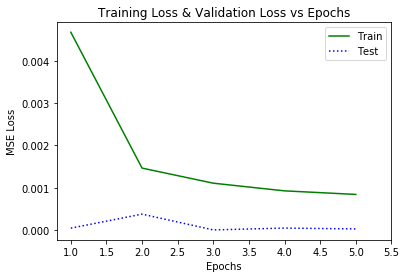

In [0]:
# #!pip install tensorboardcolab

# from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping

# tbc=TensorBoardColab()

#### check to see if parameters are ok to continue
# try:
#     contin = input("Continue with model training? (Default = (y)? ")
# except ValueError:
#     contin = "y"
    
# if contin == "n":
#     sys.exit()

print('Building model...')


# ***
# 3) number of neurons / input_nodes increased for the LSTM layer
# ***
#input_nodes = 50
input_nodes = int(150)

# trim target arrays to match input lengths
if len(trainX) < len(trainY):
    trainY = np.asmatrix(trainY[:len(trainX)])
    
if len(testX) < len(testY):
    testY = np.asmatrix(testY[:len(testX)])

model = Sequential()
# ***
# 3) Actual change on the LSTM layer
# ***

               
stop_early = EarlyStopping(monitor='val_loss', patience=2, verbose=1 )

    
model.add(LSTM(input_nodes,activation='sigmoid', 
               recurrent_activation='tanh', stateful= False,return_sequences=False,
               input_shape=(trainX.shape[1], trainX.shape[2]) ))



model.add(Dropout(0.3)) 
# for i in range(2):
#     model.add(LSTM(100,  input_shape=(trainX.shape[1], trainX.shape[2]) , stateful= False, return_sequences=True))
#     model.add(Dropout(0.3))
    
               
# model.add(LSTM(50,  input_shape=(trainX.shape[1], trainX.shape[2]) ))
    

# add dropout for generalization (default = 0.2)
# model.add(Dropout(0.3)) #- can't use dropout with Keras 2.1.2 anymore 


# 1 neuron on the output layer
model.add(Dense(1))

# compiles the model
model.compile(loss='mean_squared_error', optimizer='nadam', metrics = [metrics.mae])

print(model.summary())

# ***
# 4) Increased the batch_size to 72. This improves training performance by more than 50 times
# and loses no accuracy (batch_size does not modify the final result, only how memory is handled)
# ***
#### Start the clock




start1 = time.clock()

history = model.fit(trainX, trainY,                     
                    epochs = n_epochs,
                    batch_size = n_batch,
                    validation_data=(testX, testY)
                    ,verbose=1,  shuffle=False ,
                    callbacks = [stop_early ]
                   
                       )


    # stop clock
end1 = time.clock() 


#     return model

if (end1-start1 > 60):
    print ("Model trained in {0:.1f} minutes".format((end1-start1)/60.))
else:
    print ("Model trained in {0:.1f} seconds".format((end1-start1)/1.))
    
## save the model

model.save('LSTM_test1.model')


# ***
# 5) test loss and training loss graph. It can help understand the optimal epochs size and if the model
# is overfitting or underfitting.
# ***
xhistory = len(history.history['loss'])
xlin = range(1,xhistory+1)
plt.close('all')
plt.plot(xlin,history.history['loss'],color="g", label='Train')
plt.plot(xlin,history.history['val_loss'], color = "b", linestyle = ':', label='Test')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.xticks(np.arange(min(xlin), max(xlin)+1, (max(xlin)+1 - min(xlin))/10))
plt.title('Training Loss & Validation Loss vs Epochs')
plt.legend()
plt.show()


In [0]:
# make predictions
trainPredict = model.predict(trainX )
testPredict = model.predict(testX)

# invert predictions
if str(process) == 'y':
      trainPredict = scalerY.inverse_transform(trainPredict)
      trainY = scalerY.inverse_transform(trainY)
      testPredict = scalerY.inverse_transform(testPredict)
      testY = scalerY.inverse_transform(testY)

In [0]:
print(np.shape(trainX))
print(np.shape(trainPredict))


(79986, 5, 2)
(79986, 1)


In [0]:
# 6) calculate mean absolute error. Different than root mean squared error this one
# is not so "sensitive" to bigger errors (does not square) and tells "how big of an error"
# we can expect from the forecast on average"
# ***
print('Prediction horizon = '+ str(lead_time),'Look back = ' + str(look_back))
trainScore = mean_absolute_error(trainY, trainPredict)
print('Train Score: %.2f MAE' % (trainScore))
testScore = mean_absolute_error(testY, testPredict)
print('Test Score: %.2f MAE' % (testScore))

#####################################################

# calculate root mean squared error. 
# weights "larger" errors more by squaring the values when calculating

TrainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (TrainScore))
TestScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (TestScore))


Prediction horizon = 0 Look back = 5
Train Score: 0.00 MAE
Test Score: 0.00 MAE
Train Score: 0.01 RMSE
Test Score: 0.01 RMSE


In [0]:
print (testPredict[len(testPredict)-1])

len(testPredict) == len(testY)

print (testY[len(testY)-1])


[-0.00699213]
[[0.]]


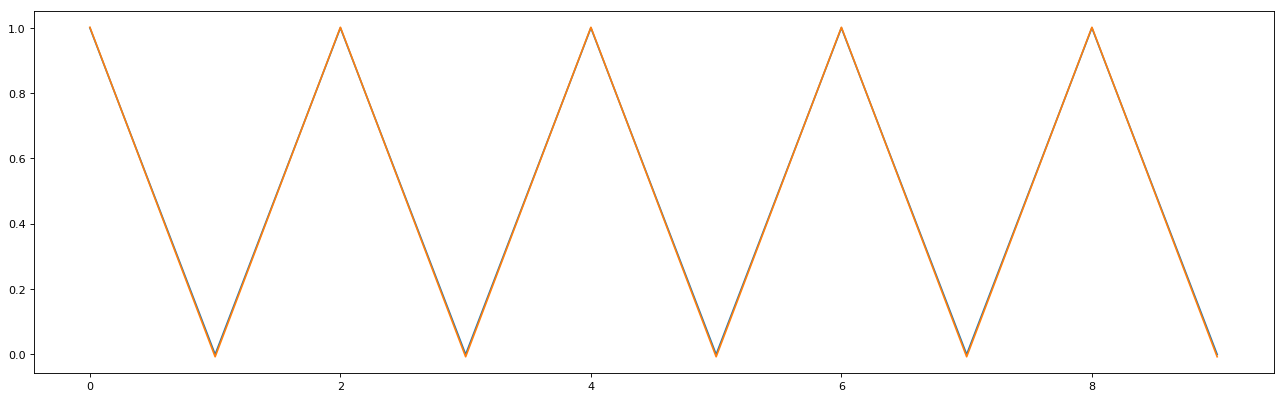

In [0]:
# plot baseline and predictions
#plt.close('all')
plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(testY[:10])
plt.plot(testPredict[:10])
plt.show()

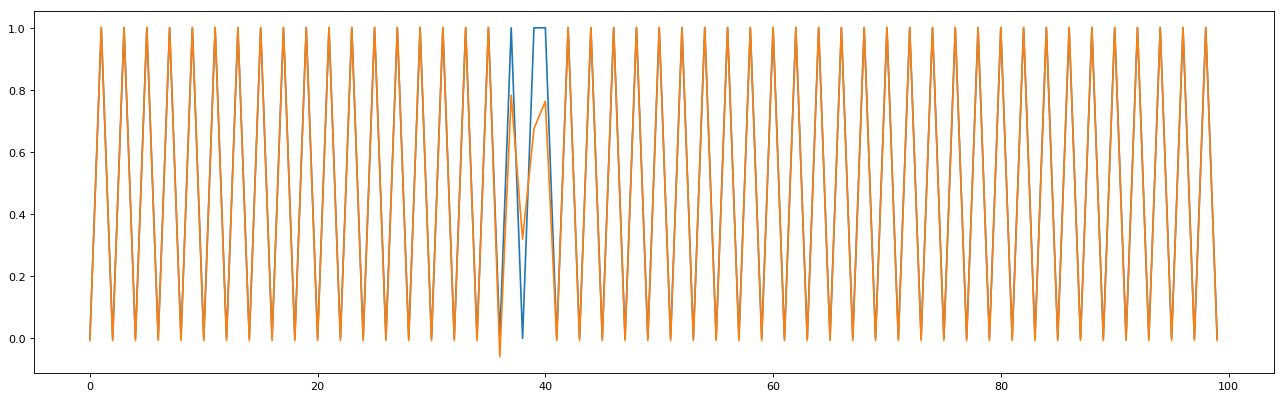

In [0]:
# plot baseline and predictions
#plt.close('all')
plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(trainY[:100])
plt.plot(trainPredict[:100])
plt.show()

In [0]:

# ########################
# ######  write results to file
# try:
#     file_write = input("Save ouput file (y/n)? (Default = n)? ")
# except ValueError:
#     file_write = "n"

# if file_write == "y":
#     # make timestamp for unique filname
#     stamp = str(time.clock())  #add timestamp for unique name
#     stamp = stamp[0:2] 

#     # generate filename and remove extra periods
#     filename = 'FinErr_lstm_'+ str(n_epochs) + str(lead_time) + '_' + stamp + '.xlsx'    #example output file
    
#     if filename.count('.') == 2:
#         filename = filename.replace(".", "",1)
#     writer = pd.ExcelWriter(filename)
#     pd.DataFrame(trainPredict).to_excel(writer,'Train-predict') #save prediction output
#     pd.DataFrame(trainY).to_excel(writer,'obs-train') #save observed output
#     pd.DataFrame(testPredict).to_excel(writer,'Test-predict') #save output training data
#     pd.DataFrame(testY).to_excel(writer,'obs_test') 
#     writer.save()
#     print('File saved in ', filename)

# Testing models on imputations

In [0]:
# print(np.shape(datatopredI))

# data = scalerX.transform(datatopredI)

# # data = np.expand_dims(data, axis=0)
# print(np.shape(data) )

# data1 = TensorForm(data,look_back)
# print(np.shape(data1) )

# PredictI = model.predict(data1)
# #invert back to real space

# # print(np.shape(PredictI))
# # print(target_col)


# X_hat = scalerY.inverse_transform(PredictI)

# print(X_hat,'\n')

# print(datatopred[:])

In [0]:
#################
## Model is built - now go impute!
############## 


# impute_file_name= drive.CreateFile({'id': '1--savgur5M36coH960hsPiQ3qJOC99u_'})
# impute_file_name.GetContentFile('Grouped_data_unfiltered.csv')

filename = 'synthetic.csv'

dfimp = pd.read_csv('synthetic.csv')


#dfimp = dfimp.drop('date',axis = 1)

dfimp = dfimp.drop(dfimp.columns[0],axis = 1)

dfi = dfimp

#dfimp = dfimp.drop(dfimp.columns[target_col],axis=1)

print(dfimp)

data_min = dfi.min()
data_max = dfi.max()

print(dfi)

dfi_np = dfi.values

dfi_np= dfi_np.reshape(-1,1)

print(np.shape(dfi_np))
#last_col_i = np.shape(dfi)[1]

#last_col_i = np.shape(dfi)[1] - 3 # do not impute the last to columns it's date encoding features

# ## convert NaNs to 1's and numbers to 0 in array df_null 0.0 to turn it to float true = missing = 1 else its zero

df_null = (dfi.isnull() + 0.).values

print('Loaded ' + filename + '...\n')
print('There are ' + str(len(dfi)) + ' total data points with ' +
       str(int(df_null.sum())) + ' observations missing' )

# ### find gaps
gaps = []

# # assumes first value of couplet is gap beginning and 2nd value is the end
for i in range(1,len(df_null)):
     if (df_null[i-1] == 0. and df_null[i] == 1.) or (df_null[i-1] == 1. and df_null[i] == 0.):
         gaps.append(i)
        
begin = gaps[0]
end = gaps[1]

print(np.shape(dfi_np))

dfi_old = copy.deepcopy(dfi_np)

        signal
0         -1.0
1          1.0
2         -1.0
3          1.0
4         -1.0
5          1.0
6         -1.0
7          1.0
8         -1.0
9          1.0
10        -1.0
11         1.0
12        -1.0
13         1.0
14        -1.0
15         1.0
16        -1.0
17         1.0
18        -1.0
19         1.0
20        -1.0
21         1.0
22        -1.0
23         1.0
24        -1.0
25         1.0
26        -1.0
27         1.0
28        -1.0
29         1.0
...        ...
99971      1.0
99972     -1.0
99973      1.0
99974     -1.0
99975      1.0
99976     -1.0
99977      1.0
99978     -1.0
99979      1.0
99980     -1.0
99981      1.0
99982     -1.0
99983      1.0
99984     -1.0
99985      1.0
99986     -1.0
99987      1.0
99988     -1.0
99989      1.0
99990     -1.0
99991      1.0
99992     -1.0
99993      1.0
99994     -1.0
99995      1.0
99996     -1.0
99997      1.0
99998     -1.0
99999      1.0
100000    -1.0

[100001 rows x 1 columns]
        signal
0         -1.0
1          1.


Gap 40 = [-0.80166459]

Gap 41 = [0.94792414]

Gap 42 = [-0.77058917]

Gap 43 = [0.86996114]

Gap 44 = [-0.83336735]


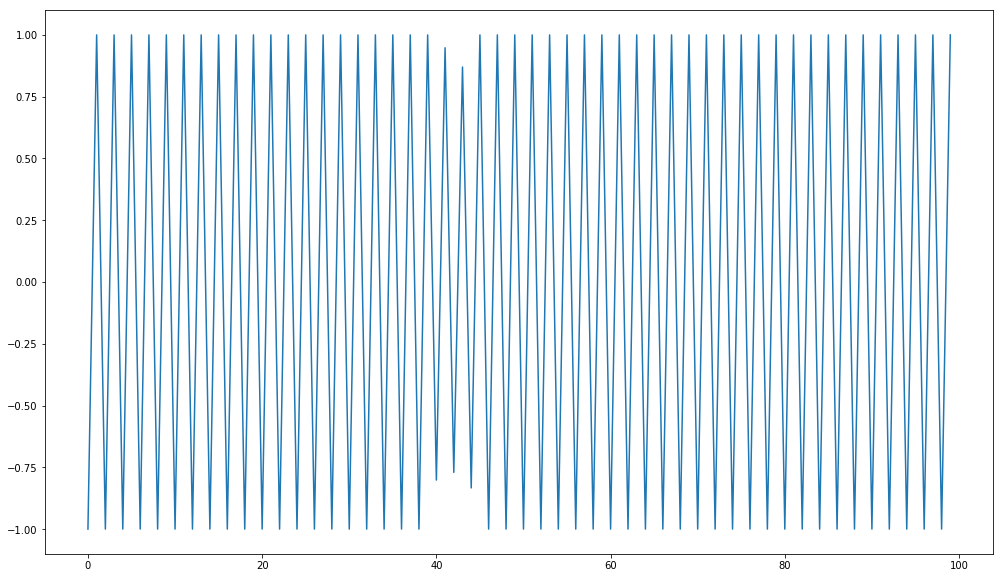

In [0]:
scalX = MinMaxScaler(feature_range=(0, 1))
scalY = MinMaxScaler(feature_range=(0, 1))

    
for mi in range(begin,end):

    dfimpSCAL = scalX.fit_transform(dfimp.values[mi-(look_back):mi,:])

    imputeX = dfi_np[mi-(look_back):mi , target_col] # take last 3 values for look back
    
    imputeX = imputeX.reshape(look_back,1)
    #add training max & min to properly scale
    imputeX = np.append(imputeX, data_min )
    imputeX = np.append(imputeX, data_max)
      
 
    imputeX = imputeX.reshape(-1,1)
    datasetI = scalY.fit_transform(imputeX) # convert to 0-1 min-max
    datasetI = datasetI[0:look_back,:] # remove min and max
          
    
    # add 2 each zero columns for tensor format
    datasetI = np.concatenate((datasetI, dfimpSCAL ), axis = 1)
    
    #print(datasetI)
                 
    dataIX = TensorForm(datasetI, look_back)  # convert to tensor
#   print(look_back)
    
#   print(np.shape(dataIX))
    
  
   #dataIX.fill
    #make predictions
    PredictI = model.predict(dataIX)
    print('')
#     print(PredictI)
    
    #invert back to real space
    dfi_np[mi] = scalerY.inverse_transform(PredictI)
    print('Gap ' + str(mi) + ' = ' + str(dfi_np[mi]) )

plt.figure(figsize=(17,10))    
plt.plot(dfi_np[:100]) 
plt.show()